Global imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

Different options for datasets

In [2]:
mnist = keras.datasets.mnist                  # 28x28, handwritten digits 0-9
fashion_mnist = keras.datasets.fashion_mnist
# couple of more

Pivotal Parameters

In [3]:
dataset = mnist
ratio_D1_D2 = 14
ratio_test_val: 6
latent_vector_size = 8

lr_autoencoder = 0.01
loss_autoencoder = "mse"
optimizer_autoencoder = "adam"
epochs_autoencoder = 5

lr_classifier = 0.01
loss_classifier = "categorical_crossentropy"
optimizer_classifier = "adam"
epochs_classifier = 8

n_autoencoder_reconstructions: 16
show_tsne = True

In [4]:
(x_train, y_train), (x_test, y_test) = dataset.load_data()

In [5]:
from utils.normalize import normalize

x_train = normalize(x_train)
x_test = normalize(x_test)

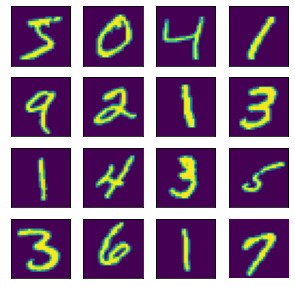

In [6]:
from utils.visualize import show_image_chunk
show_image_chunk(x_train[:16])

Size original data set:   60000 

Size training set D1:     56000
Size training set D2:     4000
----------------------------------------------------
Distribution of classes in each dataset:



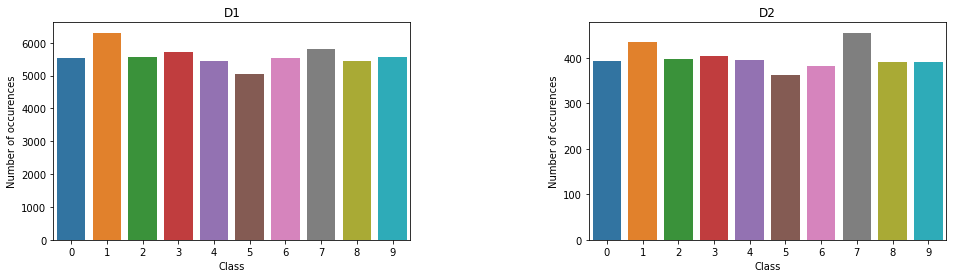

In [7]:
# divide data into D1 and D2. Test data will still be the same
from utils.data import split_data_sets
from utils.visualize import plot_distributions

print("Size original data set:  ", len(x_train), "\n")

fraq_D1 = ratio_D1_D2 / (ratio_D1_D2 + 1)
(x_train_d1, y_train_d1), (x_train_d2, y_train_d2) = split_data_sets(fraq_D1, x_train, y_train)

print("Size training set D1:    ", len(x_train_d1))
print("Size training set D2:    ", len(x_train_d2))
print("-"*52)
print("Distribution of classes in each dataset:\n")
plot_distributions([y_train_d1, y_train_d2], ["D1", "D2"])

In [8]:
# one hot encoding of categories
from tensorflow.keras.utils import to_categorical

y_train_d1 = to_categorical(y_train_d1)
y_train_d2 = to_categorical(y_train_d2)

test_labels = y_test                                  # save numerical format for later
y_test = to_categorical(y_test)

In [9]:
from models.encoder import deep_conv_encoder
from models.decoder import deep_conv_decoder

encoder = deep_conv_encoder((28, 28), latent_vector_size)
decoder = deep_conv_decoder(latent_vector_size, (28, 28))

def deep_autoencoder(encoder, decoder):
    #input_layer = keras.Input(shape=input_shape + (1, ))
    input_layer = tf.keras.Input(shape=encoder.input_shape[1:])
    encoded = encoder(input_layer)
    decoded = decoder(encoded)
    return tf.keras.Model(input_layer, decoded)

autoencoder = deep_autoencoder(encoder, decoder)

In [10]:
from models.classifier import deep_classifier

classifier_C1 = deep_classifier(10, encoder=encoder)
classifier_C2 = deep_classifier(10, input_shape=(28, 28))

In [11]:
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(x_train_d1, x_train_d1, epochs=1, batch_size=64, validation_data=(x_test, x_test), verbose=1)

875/875 [==============================] - 31s 35ms/step - loss: 0.0439 - val_loss: 0.0219


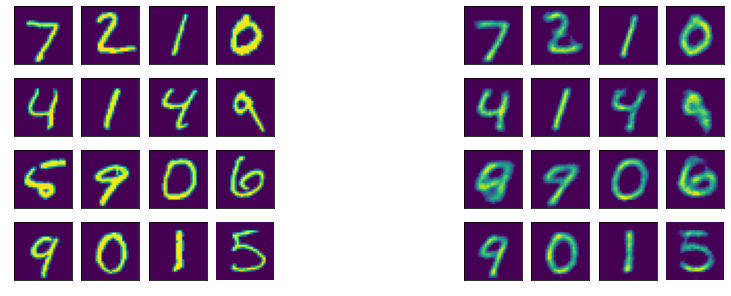

In [12]:
from utils.visualize import show_image_chunks
transformed_images = autoencoder.predict(x_test).reshape((len(x_test), 28, 28))

show_image_chunks([x_test[:16], transformed_images[:16]])
#show_image_chunk(x_test[:16])
#show_image_chunk(transformed_images[:16])


In [13]:
# Now that autoencoder is trained, the encoder module can be used for other things
# encoder = keras.Model(input_layer, latent_layer)
compressed_image_representations = encoder.predict(x_test)
compressed_image_representations[0].shape

(8,)

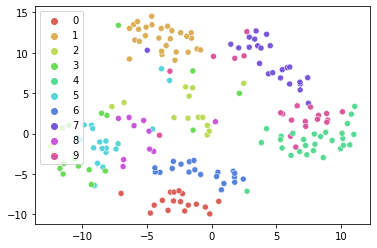

In [15]:
from utils.visualize import tsne_plot
tsne_plot(compressed_image_representations[:200], test_labels[:200])

In [ ]:
# encoder.trainable = False
from utils.callback import TrainingCallback

logs = []
classifier_C1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
classifier_C1.fit(x_train_d2[:256], y_train_d2[:256], epochs=10, batch_size=64, validation_data=(x_test[:128], y_test[:128]), verbose=1, callbacks=[TrainingCallback(logs)])
loss_C1, acc_C1 = classifier_C1.evaluate(x_test, y_test)

In [ ]:
plot_logs("Accuracy", logs, "accuracy", "Accuracy", "Categorical accuracy")

In [ ]:
classifier_C2.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
classifier_C2.fit(x_train_d2, y_train_d2, epochs=5, batch_size=64, validation_data=(x_test[:128], y_test[:128]), verbose=1)
loss_C2, acc_C2 = classifier_C2.evaluate(x_test, y_test)

In [ ]:
print("Test accuracy C1:", acc_C1)
print("Test accuracy C2:", acc_C2)